# Interpolation
<style type="text/css">
  .reveal p {
    text-align: left;
  }
  .reveal ul {
    display: block;
  }
  .reveal ol {
    display: block;
  }
</style>

In [1]:
using Plots
default(linewidth=2,legend=false)

## Introduction

* Recall our bellman equation from our first example
$$
    V(k) = \max_c \ln(c) + \beta V(Ak^\alpha - c)
$$
* We showed that if $V_j(k) = E_j + F_j \ln(k)$ then
$$
    V_{j+1}(k) = E_{j+1} + F_{j+1}\ln(k)
$$
* Here we have projected $V$ on the space of functions which are linear combinations of $1$ and $\ln(k)$
* Can this idea be extended more generally?

## Interpolation

* Want: to represent a real-valued function $f$ in a computationally tractable way
* Idea: we have a set of basis functions $\{\phi_j(x)\}_{j=0}^n$ (will go into more detail later)
* Solution: find the linear combination of these basis functions 
$$
    \tilde f(x) = \sum_{j=0}^n w_j \phi_j(x)
$$
that best fit $f$
* Now we have approximated $f$ via a vector of coefficents $w$
* We are now left with what "best fit" means

## Collocation
* We have $n+1$ coefficients, so need at least $n+1$ conditions
* Simplest idea: choose $n+1$ points $\{x_i\}_{i=0}^n$ and ensure that
$$
    \tilde f(x_i) = \sum_{j=0}^n w_j \phi_j(x_i) = f(x_i)
$$
* Best part: This is a linear system!
    * Let $\Phi$ be a matrix such that $\Phi_{ij} = \phi_j(x_i)$
    * Let $y$ be a vector such that $y_i = f(x_i)$
* Then this condition amounts to
$$
    \Phi w = y
$$
or
$$
    w = \Phi^{-1}y
$$

## Least Squares
* If we have more interpolation nodes than basis functions, then we can define residuals
$$
r = y - \Phi w
$$
* If we minimize the sum of squared residuals then
$$
    w = (\Phi'\Phi)^{-1}\Phi'y
$$
* All that remains is to decide on the basis functions
* We'll go other to types:
    * Finite element
    * Spectral basis functions

## Finite Element Methods
* Finite element methods use a **local basis**, i.e. all the basis functions are zero for a portion of the domain
* We call these approximation splines
* An order $n$ spline consists of a series of $n^{th}$ order polynomial segments
    * spliced together to preserve continuity of derivatives $n-1$ or less
* The points at which these pieces are spliced together are called knots
    * with first and last knots at the extreme of the domain

## B-Splines
* B-splines form the basis function to do spline interpolation
* Suppose we have a grid with knots $x_1<x_2<...<x_K$
* Define 
$$
    B^0_k(x) = \begin{cases}1&\text{ if $x_k\leq x < x_{k+1}$ }\\ 0&\text{otherwise}\end{cases}
$$
* Linear Splines
$$
    B^1_k(x) = \begin{cases}\frac{x-x_{k-1}}{x_k-x_{k-1}} & \text{ if $x_{k-1}\leq x < x_k$}\\ \frac{x_{k+1}-x}{x_{k+1}-x_k} & \text{if $x_k\leq x < x_{k+1}$}\\0&\text{otherwise}\end{cases}
$$

## Linear B-Spline

In [2]:
"""
    B1(x,k,xvec)

Constructs the kth linear B-splines using knot points xvec.
"""
function B1(x,k,xvec)
    n = length(xvec)
    #check if first condition is satisfied
    if x <= xvec[k] && k>1 && x >= xvec[k-1]
        return (x-xvec[k-1])/(xvec[k]-xvec[k-1])
    end
    #check if second condition
    if x >= xvec[k] && k < n && x <= xvec[k+1]
        return (xvec[k+1]-x)/(xvec[k+1]-xvec[k])
    end
    #otherwise return 0.
    return 0.
end

B1

## Plotting Linear B-Splines

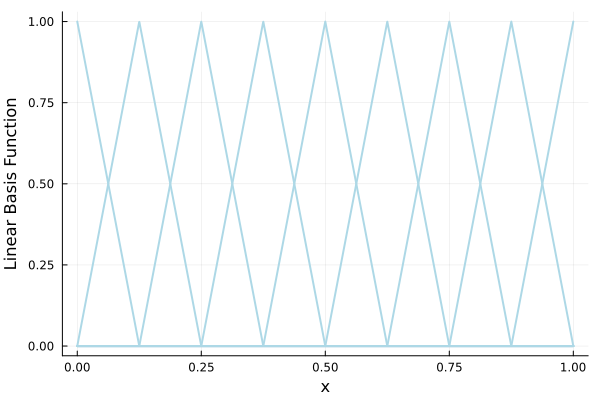

In [3]:
xvec = LinRange(0,1,9)
plt = plot(xlabel="x",ylabel="Linear Basis Function")
for k in 1:9
    plot!(x->B1(x,k,xvec),0,1,color=:lightblue)
end
plt

## Interpolation Using Linear B-Splines
* Note that only one of the B-Splines is 1 at each of the knot points
    * All the others are zero

* Therefore we can easily approximate $f$ as
$$
    \tilde f(x) = \sum_{k=1}^K f(x_k)B^1_k(x)
$$
* Note that if $x_k \leq x < x$ then
\begin{align*}
    \tilde f(x) &= f(x_k) \frac{x_{k+1}-x}{x_{k+1}-x_k} + f(x_{k+1})\frac{x-x_k}{x_{k+1}-x_k}\\
                &= f(x_k)\left(1 -\frac{x-x_k}{x_{k+1}-x_k}\right)  + f(x_{k+1})\frac{x-x_k}{x_{k+1}-x_k}\\
                &= f(x_k) + [f(x_{k+1})-f(x_k)]\frac{x-x_k}{x_{k+1}-x_k}
\end{align*}
* Which is a familiar formula for interpolation


## Example

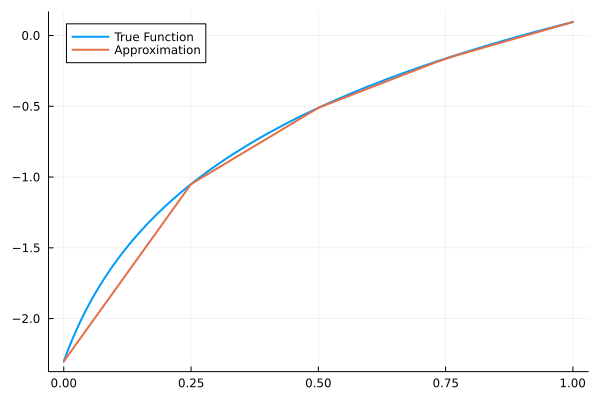

In [4]:
#Using linear B-Splines
f(x) = log.(x.+0.1) # our function to interpolate
xvec = LinRange(0,1,5) #knots for the B splines
function fhat(x,f,xvec)
    K = length(xvec)
    ret = 0.
    for k in 1:K
        ret += f(xvec[k])*B1(x,k,xvec)
    end
    return ret
end
plot(x->f(x),0,1,label="True Function",legend=true)
plot!(x->fhat(x,f,xvec),0,1,label="Approximation")

## Advantages and Disadvantages
**Pros:**

* Can preserve shape of f(monotonicity and concavity)

* Can exploit information about $f$ (relative to spectral methods later)
    * Can place more points in points of high curvature

* Can capture binding constraints very well
**Cons:**

* Approximating function is not differentiable at knots

* $\hat f''= 0$ (except at knots where it is undefined)


## Higher Order Splines
* There are extensions to higher orders via the recursion
$$
    B^n_k = \frac{x-x_k}{x_{k+n}-x_k}B^{n-1}_k(x) + \frac{x_{k+n+1}-x}{x_{k+n+1}-x_k}B^{n-1}_{k+1}(x)
$$
* Generally there are $K+n-1$ B-Splines for a given vector of knots
    * Knot vector won't match points where true function is evaluated
* Able to preserve differentiability
    * Spline function is differentiable to order n-1    
* We're going to use the BasisMatrices package
    * Gives us fine tune control over basis functions
    * Based on CompEcon which is standard

## Example

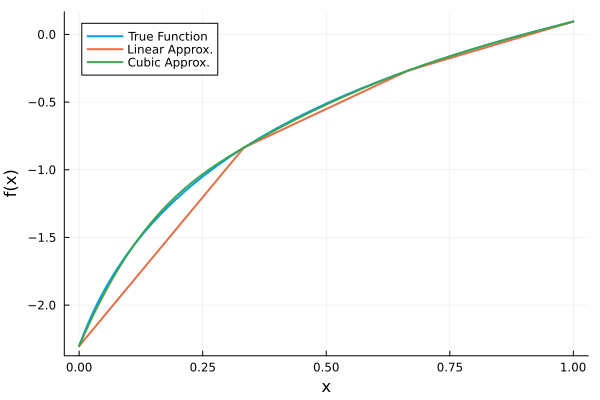

In [5]:
using BasisMatrices
#Most basic usage
xvec = LinRange(0,1,4) #break points for the B splines
fhat1 = Interpoland(SplineParams(xvec,0,1),f) #linear Interpolation
fhat3 = Interpoland(SplineParams(xvec,0,3),f) #cubic Interpolation

plot(x->f(x),0,1,label="True Function",legend=true)
plot!(x->fhat1(x),0,1,label="Linear Approx.")
plot!(x->fhat3(x),0,1,label="Cubic Approx.",ylabel="f(x)",xlabel="x")

## The Quadratic Basis Functions

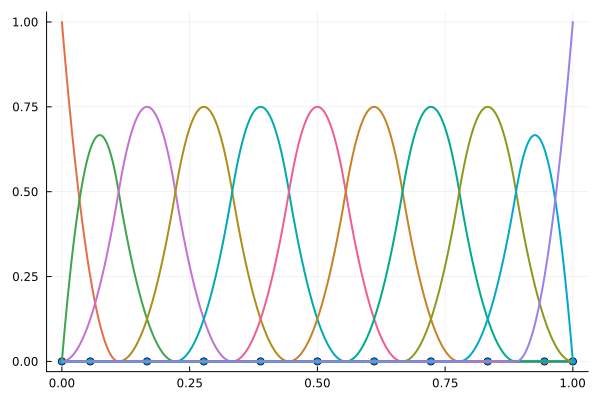

In [6]:
xvec = LinRange(0,1,10)
qbasis = SplineParams(xvec,0,2)
Φ = BasisMatrix(Basis(qbasis),Direct(),LinRange(0,1,1000)).vals[1]'
plt = scatter(nodes(qbasis),0*nodes(qbasis))
for i in 1:size(Φ,1)
    plot!(LinRange(0,1,1000),Φ[i,:])
end
plt

## Extrapolation

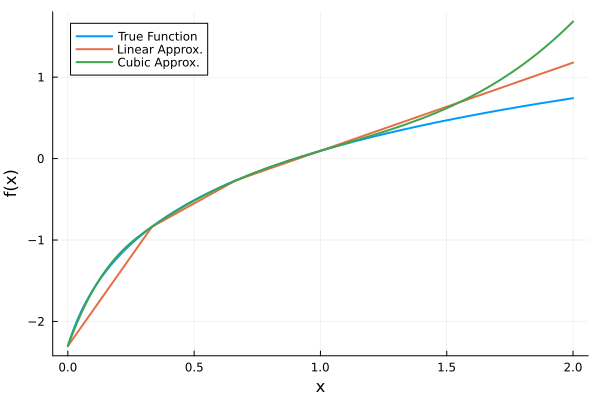

In [7]:
plot(x->f(x),0,2,label="True Function",legend=true)
plot!(x->fhat1(x),0,2,label="Linear Approx.")
plot!(x->fhat3(x),0,2,label="Cubic Approx.",ylabel="f(x)",xlabel="x")

## Advantages and Disadvantages
**Pros:**

* Easy to compute
* Smooth approximation
* Can add curvature in dimensions that need it

**Cons:**

* May not handle constraints well
* Can perform badly if function is not differentiable



## Example

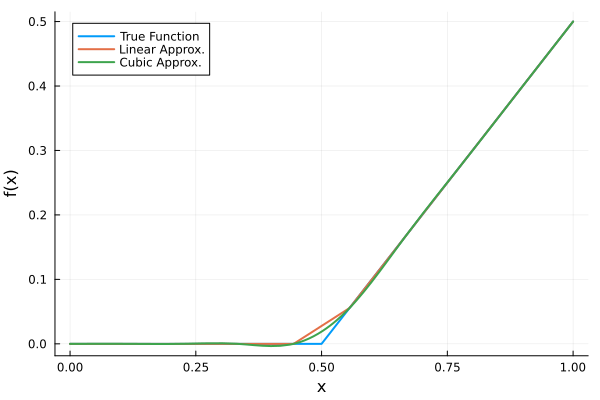

In [8]:
f2(x) = x < 0.5 ? 0 : x - 0.5 # returns 0 if x < 0.5 otherwise x - 0.5
fhat1 = Interpoland(SplineParams(xvec,0,1),x->f2.(x))
fhat3 = Interpoland(SplineParams(xvec,0,3),x->f2.(x))
plot(x->f2(x),0,1,label="True Function",legend=true)
plot!(x->fhat1(x),0,1,label="Linear Approx.")
plot!(x->fhat3(x),0,1,label="Cubic Approx.",ylabel="f(x)",xlabel="x")

# Spectral Methods

## Spectral Methods
* Finite element have the feature that their support is not the entire domain of $[a,b]$
    * i.e. $\phi_j(x) = 0$ for many $x$.
* Spectral methods approximate $f$ using basis functions whos support is the entire domain
* Generally they are some form of polynomial 
    * Choice of basis function and grid points do matter. **Why?**


## Theoretical Motivaion
* **Weierstrass Theorem**: For all continuous functions $f$ and every $\epsilon>0$ there exists a polynomial $q$ for which 
$$
    \sup_{x\in[a,b]} |f(x)-q(x)| <\epsilon
$$
* There exists a polynomial that approximates any continuous function arbitrarily well in a uniform sense
* So how do we find a good approximating polynomial?

## Equioscillation theorem
* Define 
$$
    \rho_n(f) = \inf\|f-q_n\|_\infty
$$ 
as the minimum distance between $f$ and all polynomials of degree $n$

* **Equioscillation Theorem:** If $f$ is a continuous function then theres is a unique polynomial, $q_n^*$, that achieves $\rho_n(f)$.  In addition there exists $n+1$ points $a\leq x_1<x_2<\ldots<x_{n+1}\leq b$ such that for $m=1$ or $m=-1$
$$
    f(x_j) - q^*_n(x_j) = m (-1)^j \rho_n(f)
$$
* Gives an idea of **what the errrors should look like**
    * Achieve maximum error $n+2$ times
    * Oscilate between errors
* Rule of Thumb: The closer errors are to this shape the better


## Monomial Basis
* Most naive set of polynomials for a basis function 
$$
    \phi_j(x) = x^{j-1}
$$
for $j=1,\ldots,n$
* The approximating function would then look like
$$
    \hat f(x) = w_1+ w_2 x+ w_3 x^2+\ldots+ w_n x^{n-1}
$$
* For the function evaluated at points $x_1,\ldots, x_n$ we would then solve
$$
    \left[\begin{matrix}1 & x_1 & \ldots& x_1^{n-1} \\ 
    1 & x_2 &\ldots & x_2^{n-1}\\
      & \vdots& \ddots &\vdots\\
    1& x_n&\ldots & x_n^{n-1}\end{matrix}\right]\left[\begin{matrix}w_1\\ w_2\\\vdots\\ w_n\end{matrix}\right]=\left[\begin{matrix}y_1\\ y_2\\\vdots\\ y_n\end{matrix}\right]
$$
*  This looks nice....  What's the problem?

## Plotting the Monomial Basis Functions

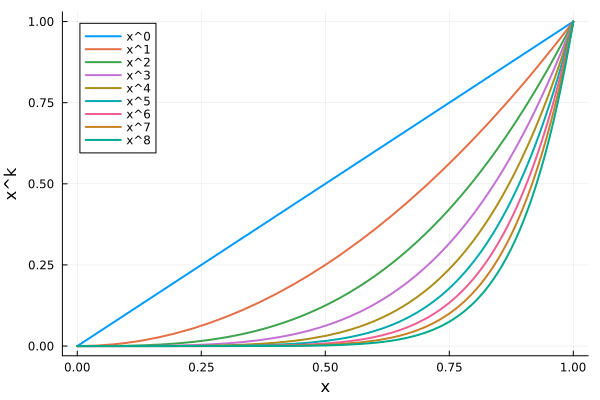

In [9]:
plt = plot(ylabel="x^k",xlabel="x",legend=true)
for k in 1:9
    plot!(x->x.^k,0,1,label="x^$(k-1)")
end
plt

## Fitting the Runge Function

In [10]:
using LinearAlgebra
n = 9
Phi = zeros(n,n)
xvec = LinRange(-1,1,n)
f_runge(x) = 1 ./(1 .+ 25 .* x.^2) #The Runge Function
yvec = zeros(n)
for i in 1:n
    for k in 1:n
        Phi[i,k] = xvec[i]^(k-1)
    end
    yvec[i] = f_runge(xvec[i])
end
w = Phi\yvec #computes coefficients for Interpolation
det(Phi) #note nearly sigular

1.0707734698911477e-6

## How Good is the fit?

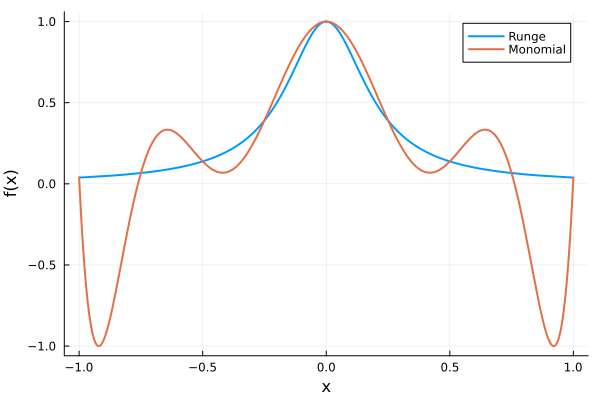

In [11]:
"""
    fhatmonomial(x,w::Array{Float64})
Computes ∑_k w_k x^(k-1)
"""
function fhatmonomial(x,w::Array{Float64})
    n = length(w)
    fhat = 0.
    for k in 1:n
        fhat += w[k]*x^(k-1)
    end
    return fhat
end
plot(f_runge,-1,1,label="Runge",legend=true)
plot!(x->fhatmonomial(x,w),-1,1,label="Monomial",xlabel="x",ylabel="f(x)")

## Othogonal Polynomials
* The reason why monomials are not a good basis is that they are not orthogonal
* **Weighting Functions:**  A function $w$ on $[a,b]$ is a positive function almost everywhere with $\int_a^b w(u)du = 1$
* **Inner Product:** For two functions $f$ and $g$ on $[a,b]$ the inner product with respect to $w$ is
$$
    <f,g> = \int_a^b f(u)g(u)w(u)du
$$

* **Orthogonal Polynomials:** A collection of polynomials $\{\phi_j\}_{j=1}^n$ is orthogonal w.r.t $w$ if $<\phi_i,\phi_k> = 0$ for all $i\neq k$
* A basis is orthonormal if 
$$
    <\phi_i,\phi_j> = \begin{cases}0&\text{if $i\neq j$}\\
    1 & \text{if $i=j$}\end{cases}
$$
* This is a good property because they do a good job of covering the entire interval.
* Common famalies of orthogonal polynomials: Chebyshev, Lagendre, Laguerre, Hermite
* We'll focus on Chebyshev

## Chebyhsev Polynomials

*  These polynomials defined by a trigometrix function
$$
    T_k = \cos((k-1)\cos^{-1}(x))
$$
Defined on $[-1,1]$
*  Alternatively have the recursive formuation
    * $T_1(x) = \cos(0) = 1$
    * $T_2(x) = \cos(\cos^{-1}(x)) = x$
    * $T_{k+1}(x) = 2xT_k(x)-T_{k-1}(x)$

## Plotting Chebyhsev Polynomials

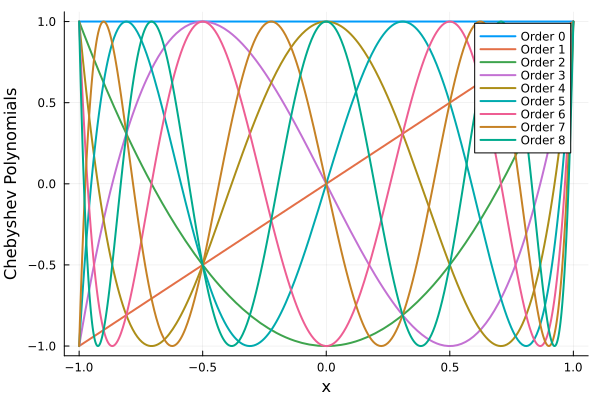

In [12]:
T(x,k) = cos.((k-1).*acos.(x))
plt = plot(xlabel="x",ylabel="Chebyshev Polynomials",legend=true)
for k in 1:9
    plot!(x->T(x,k),-1,1,label="Order $(k-1)")
end
plt

## Chebyshev Zeros
* One can show that the **interpolation nodes that minimize the error** are the zeros of the Chebyshev polynomials

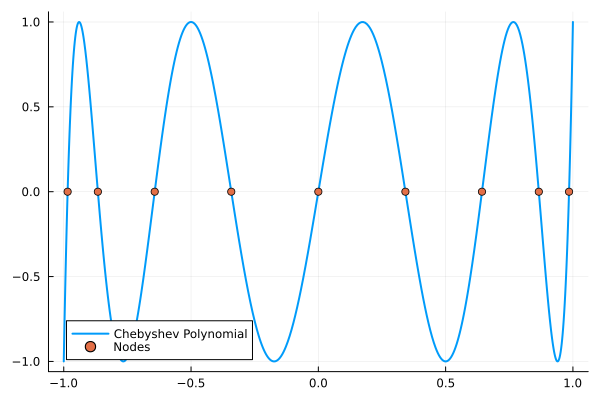

In [13]:
#using BasisMatrix code
chebbasis = Basis(ChebParams(9,-1,1))
xnodes = nodes(chebbasis)[1] #Gives nodes for the chebyshev Polynomials (zeros)
plot(x->T(x,10),-1,1,label="Chebyshev Polynomial")
scatter!(xnodes,0 .* xnodes,label="Nodes",legend=true)

* Places more weight near the ends of the grid



## Fitting with Chebyhsev Polynomials

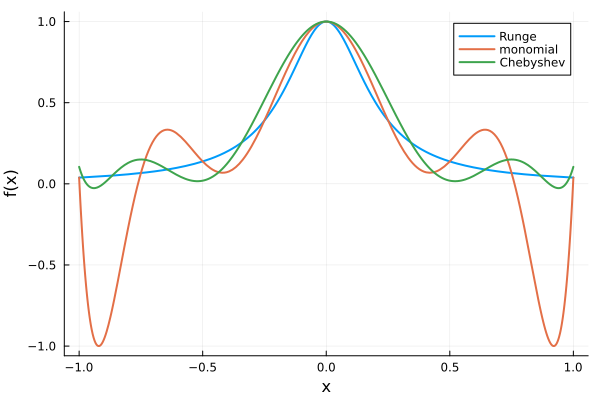

In [14]:
f_cheb = Interpoland(chebbasis,f_runge)
plot(f_runge,-1,1,label="Runge",legend=true)
plot!(x->fhatmonomial(x,w),-1,1,label="monomial")
plot!(x->f_cheb(x),-1,1,label="Chebyshev",xlabel="x",ylabel="f(x)")

## Errors

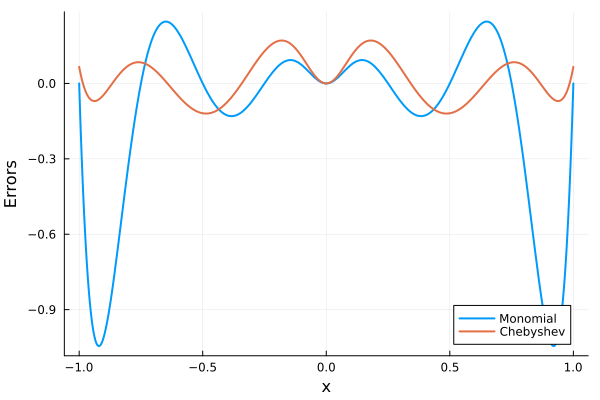

In [15]:
plot(x->fhatmonomial(x,w)-f_runge(x),-1,1,label="Monomial",legend=true)
plot!(x->f_cheb(x)-f_runge(x),-1,1,label="Chebyshev",xlabel="x",ylabel="Errors")

## Compare to Splines

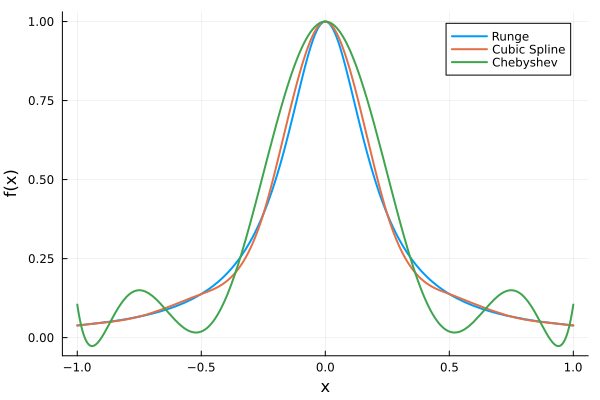

In [16]:
xgrid = LinRange(-1,1,9) #use 9 grid points like chebyshev
f_spline = Interpoland(SplineParams(xgrid,0,3),f_runge)
plot(f_runge,-1,1,label="Runge",legend=true)
plot!(x->f_spline(x),-1,1,label="Cubic Spline")
plot!(x->f_cheb(x),-1,1,label="Chebyshev",xlabel="x",ylabel="f(x)")

## Errors Relative to Splines

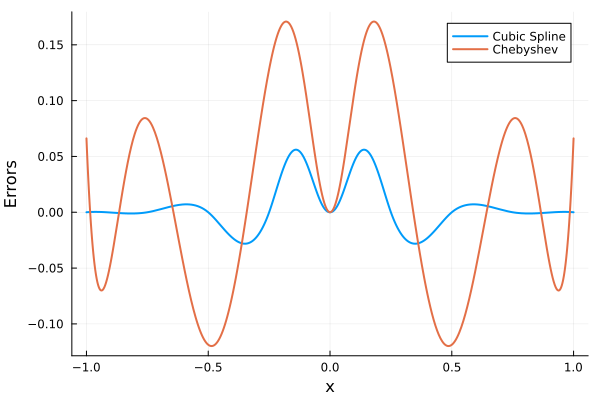

In [17]:
plot(x->f_spline(x)-f_runge(x),-1,1,label="Cubic Spline",legend=true)
plot!(x->f_cheb(x)-f_runge(x),-1,1,label="Chebyshev",xlabel="x",ylabel="Errors")

# Application to Value Function Iteration


## Value Function Iteration
* Recall our bellman equation from earlier
$$
V(k) = \max_{k'}\ln(Ak^\alpha - k')+\beta V(k')
$$
* This gives us the follow map $T$ from functions to functions
$$
    T(V)(k) = \max_{k'}\ln(Ak^\alpha - k')+\beta V(k')
$$
* Define the sequence starting at $V_0$ by 
$$
    V_n = T(V_{n-1})
$$
* We know that $V_n\rightarrow V$ with $T(V) = V$

## Adding Interpolation
* Will approximate $V_n$ using interpolation
    * Define the mapping $P$ wich takes an arbitrary function $V$ and approximates using interpolation to produce $\hat V = P(V)$
* We then have the approximation to $T$ by $\hat T$ which is given by
$$
    \hat T(V) = P(T(V))
$$
* Will be performing the following iteration
$$
    \hat V_n = \hat T(\hat V_{n-1})
$$
starting from $\hat V_0 = V_0$
* Can't guarantee convergence, but will succeed if $P$ is accurate enough

## NCParameters type

In [18]:
using Parameters
@with_kw mutable struct NCParameters
    A::Float64 = 1.
    α::Float64 = 0.3
    β::Float64 = 0.96
    kgrid::Vector{Float64} = LinRange(0.05,0.5,20)
    spline_order::Int = 3
end

NCParameters

## Computing Optimal Decision Rules

In [19]:
using Optim
"""
    optimalpolicy(para::NCParameters,Vprime,k)

Computes optimal policy using continuation value function V and current capital
level k given parameters in para.
"""
function optimalpolicy(para::NCParameters,Vprime,k)
    @unpack A,α,β,kgrid = para
    k_bounds = [kgrid[1],kgrid[end]]
    f_objective(kprime) = -( log(A*k^α-kprime)+β*Vprime(kprime) ) #stores objective as function
    k_max = min(A*k^α-.001,k_bounds[2]) #Can't have negative consumptions
    result = optimize(f_objective,k_bounds[1],k_max)
    return (kprime = result.minimizer,V=-result.minimum) #using named tuples 
end;

## Computing the Bellman Map

In [20]:
"""
    bellmanmap(Vprime,para::NCParameters)

Apply the bellman map given continuation value function Vprime
"""
function bellmanmap(para::NCParameters,Vprime::Interpoland)
    kbasis = Vprime.basis
    #sometimes it's helpful to tell julia what type a variable is
    knodes = nodes(kbasis)[1]::Vector{Float64}
    V = map(k->optimalpolicy(para,Vprime,k).V,knodes)
    return Interpoland(kbasis,V)
end;

## Solving the Bellman Map

In [21]:
"""
    solvebellman(para::NCParameters,V0::Interpoland)

Solves the bellman equation for a given V0
"""
function solvebellman(para::NCParameters,V0::Interpoland)
    diff = 1
    #Iterate of Bellman Map until difference in coefficients goes to zero
    while diff > 1e-6
        V = bellmanmap(para,V0)
        diff = norm(V.coefs-V0.coefs,Inf)
        V0 = V
    end
    kbasis = V0.basis
    knodes = nodes(kbasis)[1]::Vector{Float64}
    #remember optimalpolicy also returns the argmax
    kprime = map(k->optimalpolicy(para,V0,k).kprime,knodes)
    #Now get policies
    return Interpoland(kbasis,kprime),V0
end;

## Solving the Model

In [22]:
"""
    getV0(para::NCParameters)

Initializes V0(k) = 0 using the kgrid of para
"""
function getV0(para::NCParameters)
    @unpack kgrid,spline_order = para

    kbasis = Basis(SplineParams(kgrid,0,spline_order))

    return Interpoland(kbasis,k->0 .*k)
end
para = NCParameters()
kprime,V = solvebellman(para,getV0(para));

## Compare to True Solution

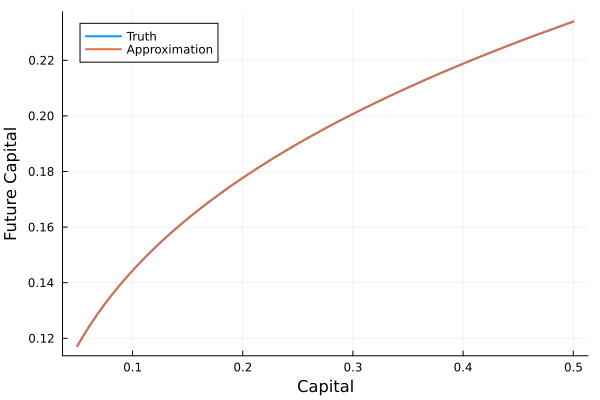

In [23]:
ktruth(para,k) = para.α.*para.β.*para.A.*k.^para.α
kmin,kmax = para.kgrid[1],para.kgrid[end]
plot(k->ktruth(para,k),kmin,kmax,label="Truth",xlabel="Capital",ylabel="Future Capital")
plot!(k->kprime(k),kmin,kmax,label="Approximation",legend=true)

## Errors Relative to True Solution

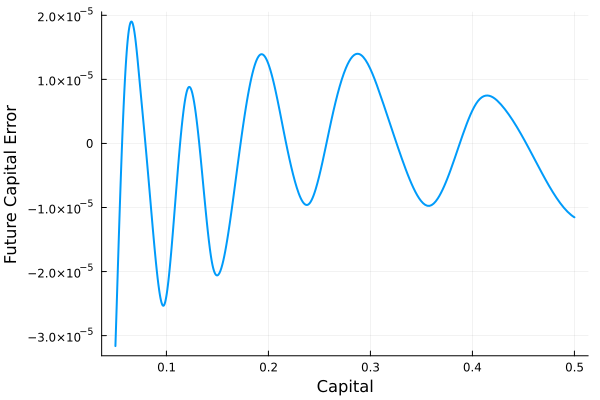

In [24]:
plot(k->kprime(k).-ktruth(para,k),kmin,kmax,xlabel="Capital", ylabel="Future Capital Error")

## Difference Between Order of Splines

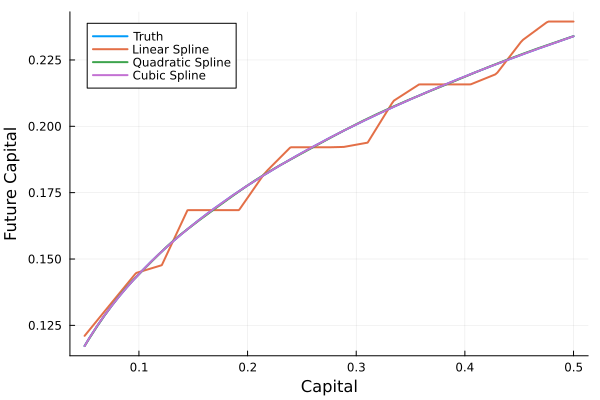

In [25]:
para.spline_order = 1
kprime1,_ = solvebellman(para,getV0(para))
para.spline_order = 2
kprime2,_ = solvebellman(para,getV0(para))
para.spline_order = 3
kprime3,_ = solvebellman(para,getV0(para))

plot(k->ktruth(para,k),kmin,kmax,label="Truth",legend=true)
plot!(k->kprime1(k),kmin,kmax,label="Linear Spline")
plot!(k->kprime2(k),kmin,kmax,label="Quadratic Spline")
plot!(k->kprime3(k),kmin,kmax,label="Cubic Spline",xlabel="Capital",ylabel="Future Capital")

## Errors

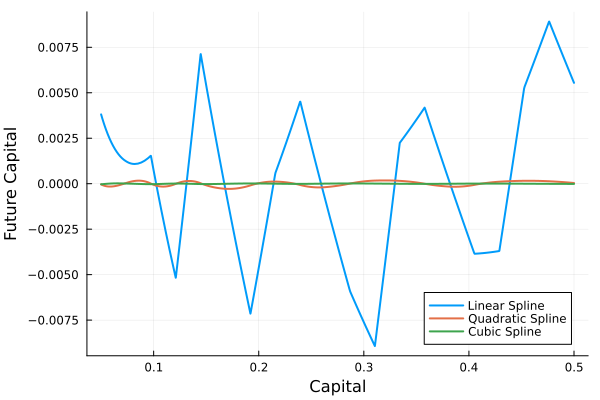

In [26]:
plot(k->kprime1(k).-ktruth(para,k),kmin,kmax,label="Linear Spline",legend=true)
plot!(k->kprime2(k).-ktruth(para,k),kmin,kmax,label="Quadratic Spline")
plot!(k->kprime3(k).-ktruth(para,k),kmin,kmax,label="Cubic Spline",xlabel="Capital",ylabel="Future Capital")


# Higher Dimensional Interpolation


## Higher Dimensional Interpolation
*  Higher dimensional function can be approximated in the same manner
$$
    f(x) \approx \sum_i\phi_i(x)c_i
$$

* $\phi_i(x)$ are now functions mapping $\mathbb R^n\rightarrow \mathbb R$

    * The basis functions for our interpolation

* Question: How do we construct these basis functions?


## 2 Dimensional Interpolation
* Lets the task of approximating an 2-dimensional function $f(x,y)$ 
    * On some bounded interval $I=[a_x,b_x]\times[a_y,b_y]$

* Let $\phi^x_i$ and $\phi^y_j$ be basis functions over $[a_x,b_x]$ and $[a_y,b_y]$ respectively
    * Assume $n_x$ basis functions for $x$ and $n_y$ for $y$

*  A natural basis for functions on $I$ is constructed using products of the basis functions
$$
    \phi_{ij}(x,y)=\phi^x_i(x)\phi^y_j(y)
$$
* These are called tensor product basis functions

* Example: basis functions with cubic on $x$ and quadratic on $y$
$$
1,x,y,xy,x^2,y^2,xy^2,x^2,y,x^2y^2,x^3,x^3y,x^3,y^2
$$


## Interpolation Nodes - 2 Dimensions 
* We can similarly construct interpolation nodes from the nodes on $x$ and $y$
    * Let $x_1,x_2,\ldots,x_{n_x}$ be the nodes on $[a_x,b_x]$
    * Let $y_1,y_2,\ldots,y_{n_y}$ be the nodes on $[a_y,b_y]$
    
* Construct nodes on $I$ by taking the Cartesian product:
$$
    \left\{(x_i,y_j)|i=1,2,\ldots,n_x;j=1,2,\ldots,n_y\right\}
$$

## Arbitrary dimensions
*  Suppose we want to approximate $f(x_1,x_2,\ldots,x_d)$ 
    * On $[a_1,b_1]\times[a_2,b_2]\times\ldots\times[a_d,b_d]$

* Start with univariate basis functions: 
    * let $\phi_{i,j}$ with $j=1,\ldots,n_i$ be the $j^{th}$ basis function along the $i^{th}$ dimension

* We can approximate $f$ using the tensor product basis functions
$$
    \hat f(x_1,\ldots,x_d) = \sum_{j_1=1}^{n_1}\cdots\sum_{j_d=1}^{n_d}\phi_{1j_1}(x_1)\cdots\phi_{dj_d}(x_d)c_{j_1\ldots j_d}
$$

* This is a bit messy, can clear this up if we let $\phi_i(x_i)$ be the vector of basis functions
    * Let $c$ be the vector of coefficients
$$
    \hat f(x_1,\ldots,x_d) = [\phi_d(x_d)\otimes\phi_{d-1}(x_{d-1})\otimes\ldots\otimes\phi_1(x_1)]c
$$

## Arbitrary dimensions (Cont)
* This is a bit messy, can clear this up if we let $\phi_i(x_i)$ be the vector of basis functions
    * Let $c$ be the vector of coefficients
$$
    \hat f(x_1,\ldots,x_d) = [\phi_d(x_d)\otimes\phi_{d-1}(x_{d-1})\otimes\ldots\otimes\phi_1(x_1)]c
$$
* What is $\otimes$???? If $A$ and $B$ are matrices we define
$$
  A\otimes B = \left[\begin{matrix}a_{11}B&\cdots&a_{1n}B\\ \vdots&\ddots&\vdots\\ a_{m1}B&\cdots&a_{mn}B\end{matrix}\right]
$$

* More compactly this defines
$$
\hat f(x) = \phi(x)c
$$

## Fitting Our Function
* Often we'll want to evaluate $\hat f$ at a bunch of points $X$
    * where $X$ is a $m\times d$ matrix

*  Define $\Phi(X)$ as a $m\times n$ matrix
    * The $i^{th}$ row is given by $\phi(X_i)$

* $\hat f(X)$ is evaluated simply as 
$$
\Phi(X)c
$$
* Let $X$ be cartesian product of the nodes of the basis functions
    * $X$ is $n\times d$

* We can fit $f(X)$ by computing coefficients
$$
    c = \Phi(X)^{-1}f(X)
$$



## Implemeting Higher Order Interpolation

In [27]:
basis_x = SplineParams(LinRange(-1,1,5),0,3) #cubic splines along x
basis_y = ChebParams(3,-1,1)#Chebyshev polynomials along y

basis = Basis(basis_x,basis_y)

2 dimensional Basis on the hypercube formed by (-1.0, -1.0) × (1.0, 1.0).
Basis families are Spline × Cheb


* Can easily get the nodes

In [28]:
X = nodes(basis)[1]

21×2 Matrix{Float64}:
 -1.0       -0.866025
 -0.833333  -0.866025
 -0.5       -0.866025
  0.0       -0.866025
  0.5       -0.866025
  0.833333  -0.866025
  1.0       -0.866025
 -1.0       -6.12323e-17
 -0.833333  -6.12323e-17
 -0.5       -6.12323e-17
  ⋮         
  0.833333  -6.12323e-17
  1.0       -6.12323e-17
 -1.0        0.866025
 -0.833333   0.866025
 -0.5        0.866025
  0.0        0.866025
  0.5        0.866025
  0.833333   0.866025
  1.0        0.866025

## Fitting the function

In [29]:
f2d = x-> exp(-x[1]^2-x[2]^2)
#compute f at each node
fvals = [f2d(X[i,:]) for i in 1:size(X,1)]

21-element Vector{Float64}:
 0.17377394345044514
 0.23587708298569995
 0.36787944117144233
 0.47236655274101463
 0.36787944117144233
 0.23587708298569995
 0.17377394345044514
 0.36787944117144233
 0.49935178859927615
 0.7788007830714049
 ⋮
 0.49935178859927615
 0.36787944117144233
 0.17377394345044514
 0.23587708298569995
 0.36787944117144233
 0.47236655274101463
 0.36787944117144233
 0.23587708298569995
 0.17377394345044514

* Fitting the function is as easy as

In [30]:
f̂ = Interpoland(basis,fvals);

## Checking Fit
* Hold $y$ fixed at one of the Chebyshev Nodes

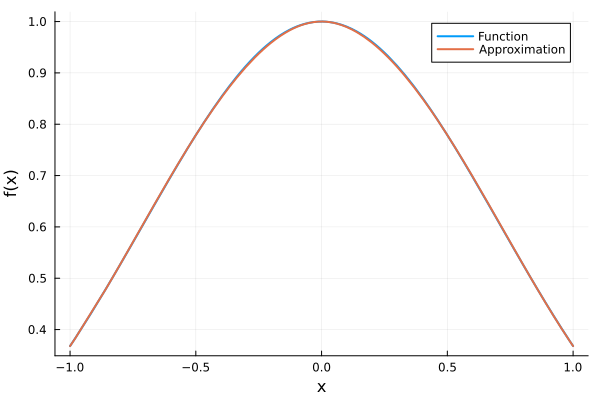

In [31]:
plot(x->f2d([x,0]),-1,1,label="Function",legend=true)
plot!(x->f̂([x,0]),-1,1,label="Approximation",xlabel="x",ylabel="f(x)")

## Checking Fit
* Hold $x$ fixed at 0

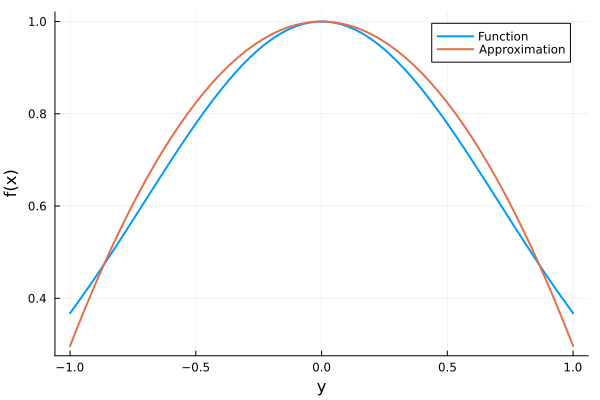

In [32]:
plot(y->f2d([0,y]),-1,1,label="Function",legend=true)
plot!(y->f̂([0,y]),-1,1,label="Approximation",xlabel="y",ylabel="f(x)")

## Checking Fit
* Hold $y$ fixed away from one of the nodes

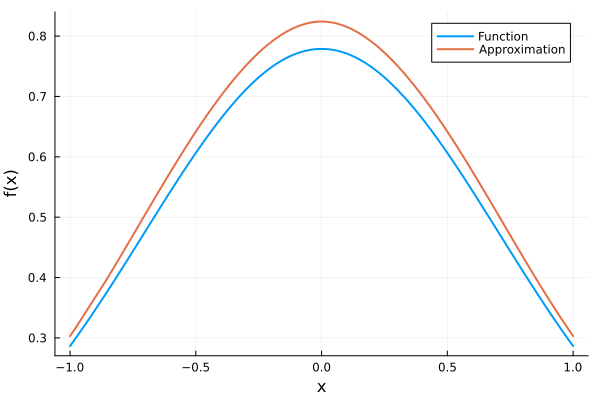

In [33]:
plot(x->f2d([x,0.5]),-1,1,label="Function",legend=true)
plot!(x->f̂([x,0.5]),-1,1,label="Approximation",xlabel="x",ylabel="f(x)")

# Optimal Taxation Revisited

## The Household Problem
* Recall that our code spent the most time on the HH problem
* Household first order condition
$$
    h^\gamma = c^{-\sigma} (1-\tau)\exp(\alpha)
$$
* Combine with budget constraint:
$$
    h^\gamma = \left((1-\tau)\exp(\alpha)h+T\right)^{-\sigma}(1-\tau)\exp(\alpha)
$$
* Note that $h$ (and hence $c$ and $U$) depends on two objects
    * The after tax wage $\hat W = (1-\tau)\exp(\alpha)$
    * Transfers $T$

* Can we pre-store the functions $h$, $c$ and $U$ to speed up our code


## Setting Up the Environment

In [34]:
using Roots
using Distributions
σ = 2. #Standard
γ = 2. #Targets Frisch elasticity of 0.5
σ_α = sqrt(0.147) #Taken from HSV
N = 1000
alphaDist = Normal(-σ_α^2/2,σ_α)
αvec = rand(alphaDist,N);

## Interpolating the HH policy functions
* Try using Chebyshev polynomials

In [35]:
"""
    approximate_household_labor(NlŴ,NT,σ,γ)

Approximates HH policies as a function of log after tax wage and transfers.
"""
function approximate_household_labor(NlŴ,NT,σ_α,σ,γ)
    lŴbasis = ChebParams(NlŴ,-5*σ_α+log(1-.8),5*σ_α)
    Tbasis = ChebParams(NT,0.,2.) #we know optimal tax will always be positive
    basis = Basis(lŴbasis,Tbasis)
    X = nodes(basis)[1]
    N = size(X,1) #How many nodes are there?
    c,h = zeros(N),zeros(N)
    for i in 1:N 
        Ŵ,T = exp(X[i,1]),X[i,2]
        res(h) = (Ŵ*h+T)^(-σ)*Ŵ-h^γ
        min_h = max(0,(.0000001-T)/Ŵ) #ensures c>.0001
        h[i] = fzero(res,min_h,20000.) #find hours that solve HH problem
        c[i] = Ŵ*h[i]+T
    end
    U = @. c^(1-σ)/(1-σ)-h^(1+γ)/(1+γ)
    return Interpoland(basis,c),Interpoland(basis,h),Interpoland(basis,U)
end;

## Government Welfare and Budget Constraint
* Adjust Government budget constraint to us pre-stored functions

In [36]:
"""
    budget_residual(τ,T,hf)

Computes the residual of the HH budget constraint given policy (τ,T)
"""
function budget_residual(τ,T,αvec,hf)
    N = length(αvec)
    X = [αvec .+ log(1-τ)  T*ones(N)]
    tax_income = sum(hf(X).*exp.(αvec).*τ)/N
    return tax_income - T
end;

* Same with objective function

In [37]:
"""
    government_welfare(τ,T,αvec,σ,γ)

Solves for government welfare given tax rate τ
"""
function government_welfare(τ,T,αvec,Uf)
    X = [αvec .+ log(1-τ)  T*ones(N)]
    return sum(Uf(X))/N
end;

## Solving For Optimal Policy
* Wrap NLopt in a function for ease of use

In [38]:
using NLopt
""" 
    find_optimal_policy(αvec,Uf,hf)

Computes the optimal policy given policy fuctions hf and indirect utility Uf
"""
function find_optimal_policy(αvec,Uf,hf)
    opt = Opt(:LN_COBYLA, 2)
    lower_bounds!(opt, [0., 0.])
    upper_bounds!(opt, [0.5,Inf])
    ftol_rel!(opt,1e-8)

    min_objective!(opt, (x,g)->-government_welfare(x[1],x[2],αvec,Uf))
    equality_constraint!(opt, (x,g) -> -budget_residual(x[1],x[2],αvec,hf))

    minf,minx,ret = NLopt.optimize(opt, [0.3, 0.3])
    if ret == :FTOL_REACHED
        return minx
    end
end;

## Let's try this out

In [39]:
cf,hf,Uf = approximate_household_labor(10,10,σ_α,σ,γ)
find_optimal_policy(αvec,Uf,hf)
@time find_optimal_policy(αvec,Uf,hf)
#Remember the old code took 2 seconds

  0.014124 seconds (14.34 k allocations: 41.162 MiB, 32.48% gc time)


2-element Vector{Float64}:
 0.36028306325890824
 0.3175456285535602

## How Does the Policy Depend On the Degree of Approximation?

In [40]:
cf,hf,Uf = approximate_household_labor(5,5,σ_α,σ,γ)
find_optimal_policy(αvec,Uf,hf)

2-element Vector{Float64}:
 0.41530825294164964
 0.35937318631665566

In [41]:
cf,hf,Uf = approximate_household_labor(10,10,σ_α,σ,γ)
find_optimal_policy(αvec,Uf,hf)

2-element Vector{Float64}:
 0.36028306325890824
 0.3175456285535602

In [42]:
cf,hf,Uf = approximate_household_labor(20,20,σ_α,σ,γ)
find_optimal_policy(αvec,Uf,hf)

2-element Vector{Float64}:
 0.36051767426043463
 0.317723139872932

* Big difference going from 5 degree to 10 degree
    * But 10 to 20 degree only effects the 4th decimal place